## PS1-5 Locally weighted linear regression

#### (a)

##### i.

Recall the cost function

\begin{align*}
J(\theta) & = \frac{1}{2} \sum_{i = 1}^{m} w^{(i)} \big( \theta^T x^{(i)} - y^{(i)} \big)^2 \\
          & = (X \theta - y)^T W (X \theta - y)
\end{align*}

Notice that there are only $m$ $w^{(i)}$'s, and $w^{(i)}$ only takes effect on the $i$-th entry of $(X \theta - y)^T$ and $(X \theta - y)$.
Hence, $W$ is a diagonal matrix, and the above equation holds by picking:

\begin{equation}
X = \begin{bmatrix}
     - (x^{(1)})^T - \\
     \vdots \\
     - (x^{(m)})^T - \\
     \end{bmatrix}
     \in \mathbb{R}^{m \times n}
\qquad
y = \begin{bmatrix}
     y^{(1)} \\
     \vdots \\
     y^{(m)} \\
     \end{bmatrix}
\qquad
W = \frac{1}{2} \mathrm{diag} (w^{(i)}, \dots , w^{(m)})
\end{equation}

##### ii.

To simplify the calculation, let $J(\theta) = \frac{1}{2} (X \theta - y)^T W (X \theta - y)$. To minimize $J$, take derivative w.r.t $\theta$ and set to 0:

\begin{align*}
\nabla_\theta J(\theta) & = \nabla_\theta \big( \frac{1}{2} (X \theta - y)^T W (X \theta - y) \big) \\
                        & = \frac{1}{2} \nabla_\theta (\theta^T X^T W X \theta - 2 y^T W X \theta + y^T W y) \\
                        & = \frac{1}{2} \nabla_\theta \big( \theta^T (X^T W X) \theta - 2 (X^T W^T y)^T \theta \big) \\
                        & = \frac{1}{2} (2 X^T W X \theta - 2 X^T W^T y) \\
                        & = X^T W X \theta - X^T W^T y \\
                        & = X^T W X \theta - X^T W y \\
                        & = 0
\end{align*}

By solving the equation, we obtain:

$$\theta = (X^T W X)^{-1} X^T W y$$

##### iii.

\begin{align*}
\ell (\theta) & = \sum_{i = 1}^{m} \log \frac{1}{\sqrt{2 \pi} \sigma^{(i)}} \exp \big( - \frac{(y^{(i)} - \theta^T x^{(i)})^2}{2 (\sigma^{(i)})^2} \big) \\
              & = - m \log \sqrt{2 \pi} \sigma^{(i)} - \sum_{i = 1}^{m} \frac{(y^{(i)} - \theta^T x^{(i)})^2}{2 (\sigma^{(i)})^2} \\
              & = - \frac{1}{2} \sum_{i = 1}^{m} \frac{1}{(\sigma^{(i)})^2} (\theta^T x^{(i)} - y^{(i)})^2 - m \log \sqrt{2 \pi} \sigma^{(i)}
\end{align*}

Thus, maximizing $\ell (\theta)$ is equivalent to minimizing

$$\frac{1}{2} \sum_{i = 1}^{m} \frac{1}{(\sigma^{(i)})^2} (\theta^T x^{(i)} - y^{(i)})^2$$

By setting $w^{(i)} = 1 / (\sigma^{(i)})^2$, finding the maximum likelihood estimate of $\theta$ reduces to minimizing $J(\theta)$.

#### (b)

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import cs229_2018_autumn.problem_sets.PS1.src.util as util

from cs229_2018_autumn.problem_sets.PS1.src.linear_model import LinearModel

In [2]:
x_train, y_train = util.load_dataset('/home/anhnt02/Desktop/learning/computer_vision/CS229/cs229_2018_autumn/problem_sets/PS1/data/ds5_train.csv', add_intercept=True)
x_valid, y_valid = util.load_dataset('/home/anhnt02/Desktop/learning/computer_vision/CS229/cs229_2018_autumn/problem_sets/PS1/data/ds5_valid.csv', add_intercept=True)
x_test, y_test = util.load_dataset('/home/anhnt02/Desktop/learning/computer_vision/CS229/cs229_2018_autumn/problem_sets/PS1/data/ds5_test.csv', add_intercept=True)

Take a look at the training set:

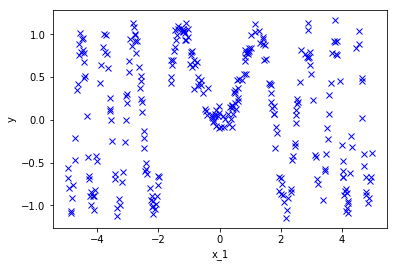

In [3]:
plt.xlabel('x_1')
plt.ylabel('y')
plt.plot(x_train[:,-1], y_train, 'bx', linewidth=2)

Implement locally weighted linear regression:

In [4]:
class LocallyWeightedLinearRegression(LinearModel):
    """Locally Weighted Regression (LWR).

    Example usage:
        > clf = LocallyWeightedLinearRegression(tau)
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def __init__(self, tau):
        super(LocallyWeightedLinearRegression, self).__init__()
        self.tau = tau
        self.x = None
        self.y = None

    def fit(self, x, y):
        """Fit LWR by saving the training set.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """

        self.x = x
        self.y = y

    def predict(self, x):
        """Make predictions given inputs x.

        :param x: Inputs of shape (l, n).
        :return:  Outputs of shape (l,).
        """

        l, n = x.shape

        # Reshape the input x by adding an additional dimension so that it can broadcast
        w_vector = np.exp(- np.linalg.norm(self.x - np.reshape(x, (l, -1, n)), ord=2, axis=2)**2 / (2 * self.tau**2))

        # Turn the weights into diagonal matrices, each corresponds to a single input. Shape (l, m, m)
        w = np.apply_along_axis(np.diag, axis=1, arr=w_vector)

        # Compute theta for each input x^(i). Shape (l, n)
        theta = np.linalg.inv(self.x.T @ w @ self.x) @ self.x.T @ w @ self.y

        return np.einsum('ij,ij->i', x, theta)

Train the model:

In [5]:
clf = LocallyWeightedLinearRegression(tau=0.5)
clf.fit(x_train, y_train)

Plot predictions on training set and validation set:

In [6]:
def plot(x, y_label, y_pred, title):
    plt.figure()
    plt.plot(x[:,-1], y_label, 'bx', label='label')
    plt.plot(x[:,-1], y_pred, 'ro', label='prediction')
    plt.suptitle(title, fontsize=12)
    plt.legend(loc='upper left')

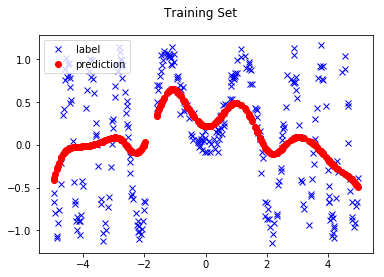

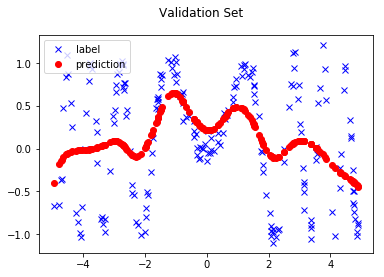

In [7]:
y_train_pred = clf.predict(x_train)
plot(x_train, y_train, y_train_pred, 'Training Set')

y_valid_pred = clf.predict(x_valid)
plot(x_valid, y_valid, y_valid_pred, 'Validation Set')

From the figures, we can see the model is underfitting.

#### (c)

Tau = 0.05 achieves the lowest MSE on the validation set.


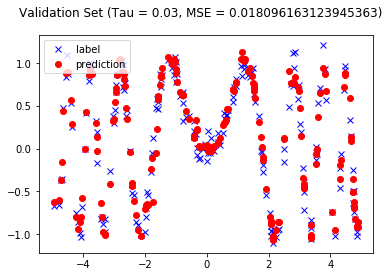

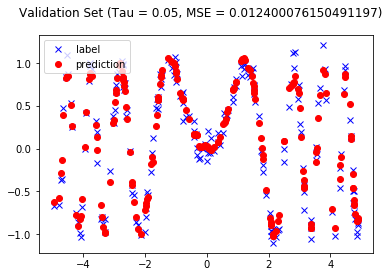

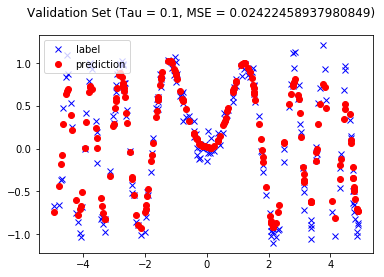

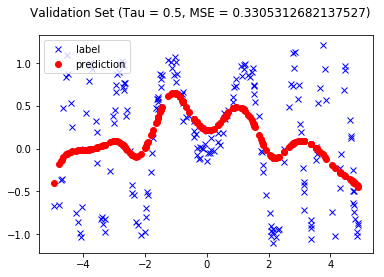

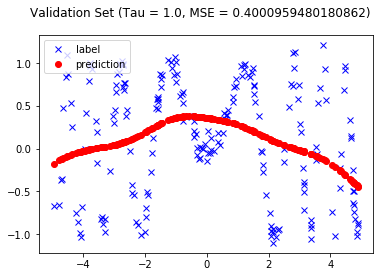

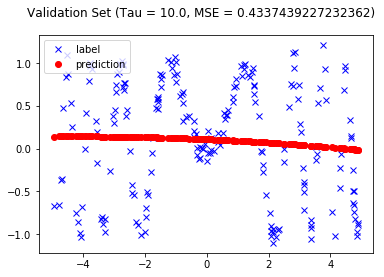

In [8]:
taus = [3e-2, 5e-2, 1e-1, 5e-1, 1e0, 1e1]

lowest_mse = math.inf
best_tau = taus[0]

for tau in taus:
    clf = LocallyWeightedLinearRegression(tau)
    clf.fit(x_train, y_train)
    y_valid_pred = clf.predict(x_valid)

    mse = np.mean((y_valid_pred - y_valid)**2)
    if mse < lowest_mse:
        lowest_mse = mse
        best_tau = tau

    plot(x_valid, y_valid, y_valid_pred, f'Validation Set (Tau = {tau}, MSE = {mse})')

print(f'Tau = {best_tau} achieves the lowest MSE on the validation set.')

Use $\tau = 0.05$ to make predictions on test set:

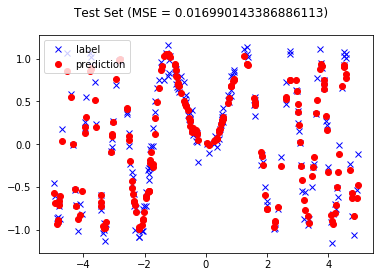

In [9]:
clf = LocallyWeightedLinearRegression(tau=0.05)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

plot(x_test, y_test, y_test_pred, f'Test Set (MSE = {np.mean((y_test_pred - y_test)**2)})')